# Importing libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn import neighbors
#from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
#from scipy.spatial.distance import cdist


# import datasets:
#movies = pd.read_csv('/kaggle/input/movielens20/ml-20m/movies.csv')
#ratings = pd.read_csv('/kaggle/input/movielens20/ml-20m/ratings.csv')
#tags = pd.read_csv('/kaggle/input/movielens20/ml-20m/tags.csv')
#links =  pd.read_csv('/kaggle/input/movielens20/ml-20m/links.csv')
#genome_tags = pd.read_csv('/kaggle/input/movielens20/ml-20m/genome-tags.csv')
#genome_scores =  pd.read_csv('/kaggle/input/movielens20/ml-20m/genome-scores.csv')

movies = pd.read_csv('/home/mumu/Documents/formations/Datascietest/study/Project/ml-20m/movies.csv')
ratings = pd.read_csv('/home/mumu/Documents/formations/Datascietest/study/Project/ml-20m/ratings.csv')
tags = pd.read_csv('/home/mumu/Documents/formations/Datascietest/study/Project/ml-20m/tags.csv')


# Preprocessing

In [2]:
# Create a dataframe with movieId and userId containing user ratings:
ratings_1 = ratings[["movieId", "userId", 'rating' ]]
movies_1 = movies[["movieId", "title" ]]
data=pd.merge(movies_1, ratings_1, on="movieId")

# Reducing the dataframe by removing unpopular movies and anactive 

#Shringking movies
gf = pd.DataFrame(data['movieId'].value_counts())
rare_movies = gf[gf['movieId'] <= 1000].index
final_df = data[~data["movieId"].isin(rare_movies)]
print('Out of total of ', gf.shape[0] , ' movies, ', rare_movies.shape[0], ' are considered rare and will be removed.')
print('The final number of movies is ', final_df["movieId"].nunique())

#Shringking users
udf = pd.DataFrame(data['userId'].value_counts())
lazy_users = udf[udf['userId'] <= 500].index
final_df = final_df[~final_df["userId"].isin(lazy_users)]
print('Out of total of ', udf.shape[0] , ' users, ', lazy_users.shape[0], ' are considered lazy and will be removed.')
print('The final number of users is ', final_df["userId"].nunique())

# Create the user->movie sparse rating matrix. Fill the NA with zeros
pivot = final_df.pivot_table(index="userId", columns="title", values="rating")
pivot.fillna(0,inplace=True)

#Estimate sparsity
sparsity = 1.0 - ( np.count_nonzero(pivot) / float(pivot.size) )
print("The resulting sparcity of hte matrix is:", sparsity)

#Create non-sparce dataset

csr_data = csr_matrix(pivot.values)

Out of total of  26744  movies,  23585  are considered rare and will be removed.
The final number of movies is  3159
Out of total of  138493  users,  131052  are considered lazy and will be removed.
The final number of users is  7441
The resulting sparcity of hte matrix is: 0.7767520023190557


# Modelling
Below we execute the following steps:
* Randomly choosing a target user fo whom recommendations will be generated
* Pre-clustering of users using KMeans model
* Creating a new matrix corresponding with users in the target user cluster
* Defining the Mean User Vector for the working data matrix
* Training the Nearest Neighbors model on the Mean User Vector
* Processing the results of the NN modeling: collecting, aggregating, filtering results and presenting recommendations

## Pre-clustering with KMeans

In [9]:
# Pre-clustering users with K-means
# 20 clusters
kmeans = KMeans(n_clusters=20, algorithm='lloyd', n_init='auto').fit(csr_data) # Demands lots of resources
labels = kmeans.labels_ 
unique, counts = np.unique(labels, return_counts=True)

print("The number of users per class:\n")
for u, c in zip(unique, counts):
    print(u, c)

The number of users per class:

0 382
1 598
2 447
3 501
4 257
5 360
6 334
7 423
8 149
9 373
10 264
11 487
12 350
13 249
14 462
15 196
16 119
17 401
18 451
19 638


In [10]:
# Let's randomly choose an existing user
user_index = np.random.choice(csr_data.shape[0])    
print('The target user belongs to the cluster number', labels[user_index])

# Creating the csr matrix only for usrs of the cluster of the target user
# get indices of the users in the selected cluster
cluster_user_indices = []
for i,l in enumerate(labels):
    if l == labels[user_index]:
        cluster_user_indices.append(i)
        
# create a new csr_data only with the users from the cluster
mask = np.zeros(csr_data.shape[0], dtype=bool)
mask[cluster_user_indices] = True

csr_data_cluster = csr_data[mask]

# When shrinking the matrix, the index of the target user chenges to the new_user_index
new_user_index = np.nonzero(np.array(cluster_user_indices) == user_index)[0][0]

# Calculating the mean users' ratings
def calculate_mean_user_vector(csr_data):
    csr_mean = csr_data.sum(axis=1)/csr_data.getnnz(axis=1)
    mean_user_vector = np.asarray(csr_mean)
    flattened_reshaped = mean_user_vector.mean(axis=1).flatten().reshape(-1, 1)
    return mean_user_vector.reshape(-1), flattened_reshaped

mean_user_vector, model_mean_user_vector = calculate_mean_user_vector(csr_data_cluster)

The target user belongs to the cluster number 15


## NN with mean user vector

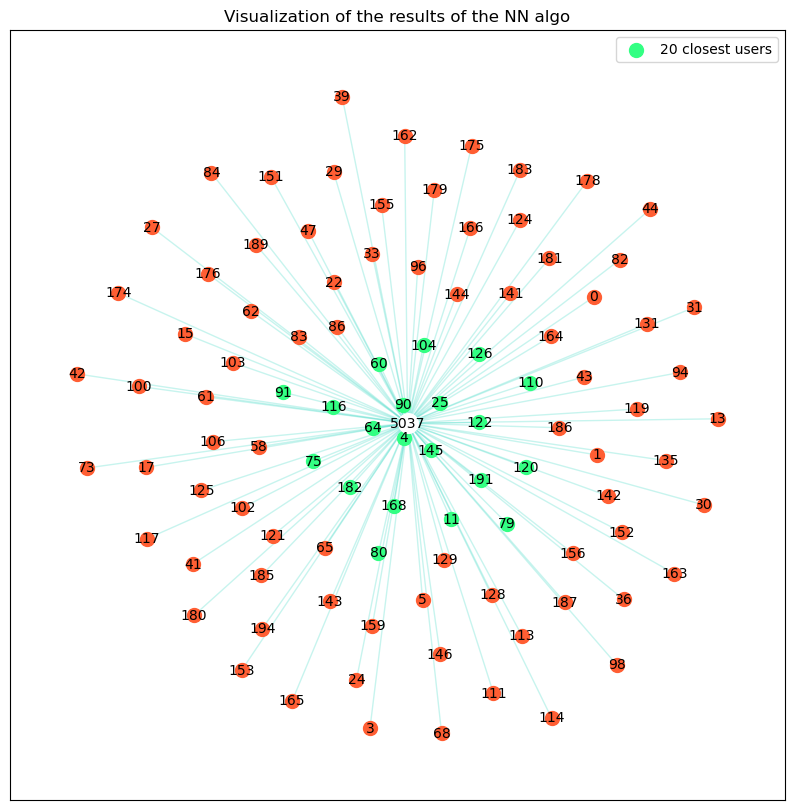

In [11]:
# Create NN object and fit it with the mean user vector

number_of_closest_users = 100
nn = neighbors.NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=number_of_closest_users)
nn.fit(model_mean_user_vector)
number_of_most_closest_users = 20 # for visualization purpose only
nn_sub = neighbors.NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=number_of_most_closest_users)
nn_sub.fit(model_mean_user_vector)

# Find the nearest neighbors for a specific user (e.g., User1)
distances, indices = nn.kneighbors(model_mean_user_vector[new_user_index].reshape(1, -1))
distances_sub, indices_sub = nn_sub.kneighbors(model_mean_user_vector[new_user_index].reshape(1, -1))

# Exercise: visualize the results as graph
import networkx as nx

G = nx.Graph()
G.add_node(user_index)

closest_users = indices.reshape(-1)[1:]
closest_users_sub = indices.reshape(-1)[1:number_of_most_closest_users +1]
closest_users_remaining = indices.reshape(-1)[number_of_most_closest_users+1 :]

G.add_nodes_from(indices.reshape(-1)[1:])

weigths = 1/(distances.reshape(-1)[1:]+ 0.00001)

G.add_weighted_edges_from(list((user_index, n, w) for n,w in zip(closest_users,weigths)))

pos = nx.fruchterman_reingold_layout(G)

plt.figure(figsize = (10, 10))
ax = plt.axes()
ax.set_facecolor("white")
plt.title("Visualization of the results of the NN algo")

nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_remaining, node_color = "#ff5e33")
nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_sub, node_color = "#33ff83", label= str(number_of_most_closest_users) + " closest users")
nx.draw_networkx_nodes(G, pos, node_size = 200, nodelist = [user_index], node_color = "#ffffff")
nxlabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edges(G, pos, alpha = 0.3, edge_color = "#48dbc8")
#nx.draw_networkx_edge_labels(G,pos,edge_labels=nxlabels)
#nx.draw_networkx_labels(G,pos,font_size=10, labels={user_index: user_index})
nx.draw_networkx_labels(G,pos,font_size=10)
plt.grid(visible=False)
plt.legend()
plt.show()

## Postprocessing

In [12]:
# Collecting ratings from the closers users
def keep_rows_csr(mat, indices):
    """
   Keep the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    #if not isinstance(mat, scipy.sparse.csr_matrix):
     #   raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = indices.flatten()
    mask = np.zeros(mat.shape[0], dtype=bool)
    mask[indices] = True
    return mat[mask]
    

# a csr matrix with the closes users only
csr_data_closests_users = keep_rows_csr(csr_data_cluster, indices)

# Aggregating the ratings from the closest users
# calculate the averaged rating of the movies given by the neiboghrs

def closest_users_average_ratings(mat):
    mat_array = mat.toarray()
    mat_array[mat_array == 0] = np.nan
    return np.nanmean(mat_array, axis=0)

rating_aggregation = closest_users_average_ratings(csr_data_closests_users)

# rank them by sorting

movies_indices_sorted_desc = np.argsort(rating_aggregation)[::-1]
best_20_movies = movies_indices_sorted_desc[:20]

# Filtering:
# get the user movies row
mask = np.zeros(csr_data_cluster.shape[0], dtype=bool)
mask[new_user_index] = True
target_user_row = csr_data_cluster[mask].toarray().flatten()

# get indices of the unwatched movies
unwatched_indices = np.nonzero(target_user_row == 0)

# keep only unwatches movie indices
filter_arr = []
for element in movies_indices_sorted_desc:
  if element in unwatched_indices[0]:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

movies_to_watch =  movies_indices_sorted_desc[filter_arr]

# Provide personalised recommendations
watched_indices = np.nonzero(target_user_row != 0)

filter_arr = []
for element in movies_indices_sorted_desc:
  if element in watched_indices[0]:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

watched_movies =  movies_indices_sorted_desc[filter_arr]

def get_movie_titles_by_indices(indices):
    titles = []
    for i in indices:
        titles.append(pivot.columns[i])
    return titles

print("User " + str(user_index) + " watched and rated the following movies:\n")
for index, movie in enumerate(get_movie_titles_by_indices(watched_movies)[:20]):
    print(str(index+1), ":", str(movie))
print("\n")
print("Recommendation for User " + str(user_index) + ":\n")
for index, movie in enumerate(get_movie_titles_by_indices(movies_to_watch)[:20]):
    print(str(index+1), ":", str(movie))

User 5037 watched and rated the following movies:

1 : Shawshank Redemption, The (1994)
2 : Usual Suspects, The (1995)
3 : Sixth Sense, The (1999)
4 : Silence of the Lambs, The (1991)
5 : American History X (1998)
6 : Forrest Gump (1994)
7 : Dead Poets Society (1989)
8 : Breakfast Club, The (1985)
9 : Lord of the Rings: The Fellowship of the Ring, The (2001)
10 : Stand by Me (1986)
11 : Princess Bride, The (1987)
12 : Good Will Hunting (1997)
13 : Rain Man (1988)
14 : Ferris Bueller's Day Off (1986)
15 : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
16 : Goodfellas (1990)
17 : Seven (a.k.a. Se7en) (1995)
18 : Fight Club (1999)
19 : Godfather, The (1972)
20 : Back to the Future (1985)


Recommendation for User 5037:

1 : Paris, Texas (1984)
2 : Wolf of Wall Street, The (2013)
3 : Night of the Hunter, The (1955)
4 : Terminator Salvation (2009)
5 : Night on Earth (1991)
6 : Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)
7 : Stranger Than Parad

/tmp/ipykernel_119524/138751650.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(mat_array, axis=0)
